![ADME](https://storage.googleapis.com/polaris-public/icons/icons8-whale-96-ADME.png) 

# `polaris/adme-fang-1` data curation


## Background

The goal of accessing ADME properties is to understand how a potential drug candidate interacts with the human body, including absorption, distribution, metabolism, and excretion. This knowledge is crucial for evaluating efficacy, safety, and clinical potential, guiding drug development for optimal therapeutic outcomes. Fang et al. 2023 has disclosed DMPK datasets collected over 20 months across six ADME in vitro endpoints, which are human and rat liver microsomal stability, MDR1-MDCK efflux ratio, solubility, and human and rat plasma protein binding. The dataset contains 885 to 3087 measures for the corresponding endpoints. The compounds show the chemical diversity across all ranges of the endpoints which are microsomal stability, plasma protein binding, permeability, and solubility.

## Description of readout
- Microsomal stability (human and rat):  `LOG HLM_CLint (mL/min/kg)`, `LOG RLM_CLint (mL/min/kg)`
- Plasma protein binding (human and rat): `LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)`, `LOG PLASMA PROTEIN BINDING (RAT) (% unbound)`
- Permeability: `LOG MDR1-MDCK ER (B-A/A-B)`
- Solubility: `LOG SOLUBILITY PH 6.8 (ug/mL)`


## Data resource
**Reference**: [Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective]( https://doi.org/10.1021/acs.jcim.3c00160)

**Github**: https://github.com/molecularinformatics/Computational-ADME

**Raw data**: https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv 

## Dataset entry point on Polaris
The dataset is available on Polaris [polaris/adme-fang-1](https://polarishub.io/datasets/polaris/adme-fang-1). 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import datetime
import re
import warnings

os.chdir(pathlib.Path("__file__").absolute().parents[1])
import datamol as dm
import pandas as pd
from polaris import curation
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.curation.viz_utils import check_undefined_stereocenters

warnings.filterwarnings("ignore")


In [2]:
# load data
data = dm.read_csv("gs://polaris-public/data/raw/fang2023_ADME_public_set_3521.csv")

In [3]:
# Define data column names
endpoints = {
    "HLM": "LOG HLM_CLint (mL/min/kg)",
    "RLM": "LOG RLM_CLint (mL/min/kg)",
    "hPPB": "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)",
    "rPPB": "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)",
    "MDR1_ER": "LOG MDR1-MDCK ER (B-A/A-B)",
    "Sol": "LOG SOLUBILITY PH 6.8 (ug/mL)",
}
data_cols = list(endpoints.values())
mol_col = "SMILES"

In [4]:
data.describe()[data_cols]

,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
count,3087.000000,3054.000000,194.000000,168.000000,2642.000000,2173.000000
mean,1.320019,2.256207,0.765722,0.764177,0.397829,1.259943
std,0.623952,0.750422,0.847902,0.798988,0.688465,0.683416
min,0.675687,1.027920,-1.593460,-1.638272,-1.162425,-1.000000
25%,0.675687,1.688291,0.168067,0.226564,-0.162356,1.153510
50%,1.205313,2.311068,0.867555,0.776427,0.153291,1.542825
75%,1.803115,2.835274,1.501953,1.375962,0.905013,1.687351
max,3.372714,3.969622,2.000000,2.000000,2.725057,2.179264


### Perform data curation with `polaris.curation` module
The curation process includes:
- assign unique identifier to molecules
- detect the stereochemistry information of molecules.
- inspect the potential outliers of bioactivity values
- merge rows of replicated molecules
- detect isomers which show the activity shifts

Check out the curation module in [Polaris](https://github.com/polaris-hub/polaris/blob/79b5d4e99d857eaa679042f47d8b3c90f96dd896/polaris/curation/_curator.py#L13C7-L13C23). 

In [5]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data, # original dataset in pandas.DataFrame
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False, # whether remove all molecules which has undefined stereochemistry information
    keep_all_rows = True
)
df_full = curator()

2024-03-25 16:22:52.116 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOG HLM_CLint (mL/min/kg) using zscore. Please revise the data and consider remove the outliers. 
2024-03-25 16:22:52.120 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG PLASMA PROTEIN BINDING (RAT) (% unbound) using zscore. Please revise the data and consider remove the outliers. 
2024-03-25 16:22:52.121 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG MDR1-MDCK ER (B-A/A-B) using zscore. Please revise the data and consider remove the outliers. 
2024-03-25 16:22:52.122 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 20 outliers for data column LOG SOLUBILITY PH 6.8 (ug/mL) using zscore. Please revise the data and consider remove the outliers. 


In [6]:
df_full[['OUTLIER_LOG RLM_CLint (mL/min/kg)',
       'OUTLIER_LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)',
       'OUTLIER_LOG PLASMA PROTEIN BINDING (RAT) (% unbound)',
       'OUTLIER_LOG MDR1-MDCK ER (B-A/A-B)',
       'OUTLIER_LOG SOLUBILITY PH 6.8 (ug/mL)',]]

,OUTLIER_LOG RLM_CLint (mL/min/kg),OUTLIER_LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),OUTLIER_LOG PLASMA PROTEIN BINDING (RAT) (% unbound),OUTLIER_LOG MDR1-MDCK ER (B-A/A-B),OUTLIER_LOG SOLUBILITY PH 6.8 (ug/mL)
0,False,None,None,None,None
1,False,None,None,False,False
2,False,None,None,False,False
3,False,None,None,False,False
4,False,None,None,False,False
...,...,...,...,...,...
3516,False,None,None,False,None
3517,False,None,None,False,None
3518,None,None,None,None,False
3519,False,None,None,False,None


## Check the outliers of the bioactivity 

During the curation process, several potential outliers were flagged across multiple endpoints. These outliers have been marked and included in the curated output. It's essential to revisit these flagged data points to confirm whether they truly are outliers and should therefore be excluded from the final dataset. \
This process utilized `zscore` as the default method, but one can adjust the outlier detection method by defining parameters within the `outlier_params`. For more information and details on this, please refer to `polaris.curation.utils.outlier_detection`.

In [7]:
data_cols

['LOG HLM_CLint (mL/min/kg)',
 'LOG RLM_CLint (mL/min/kg)',
 'LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)',
 'LOG PLASMA PROTEIN BINDING (RAT) (% unbound)',
 'LOG MDR1-MDCK ER (B-A/A-B)',
 'LOG SOLUBILITY PH 6.8 (ug/mL)']

[<Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x400 with 2 Axes>]

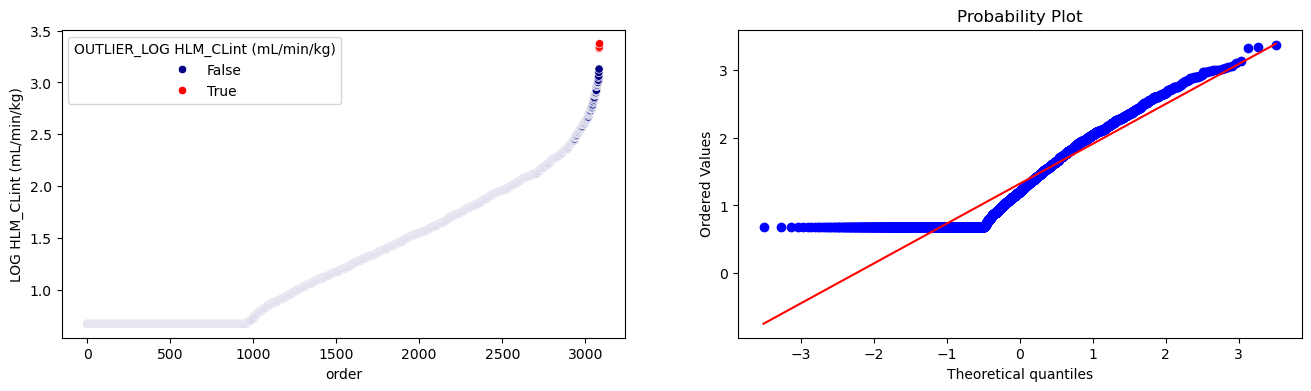

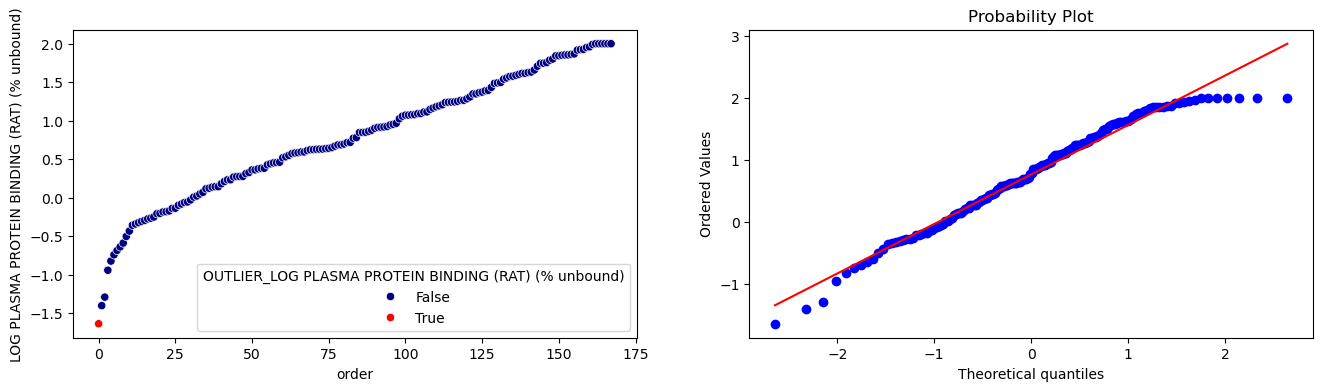

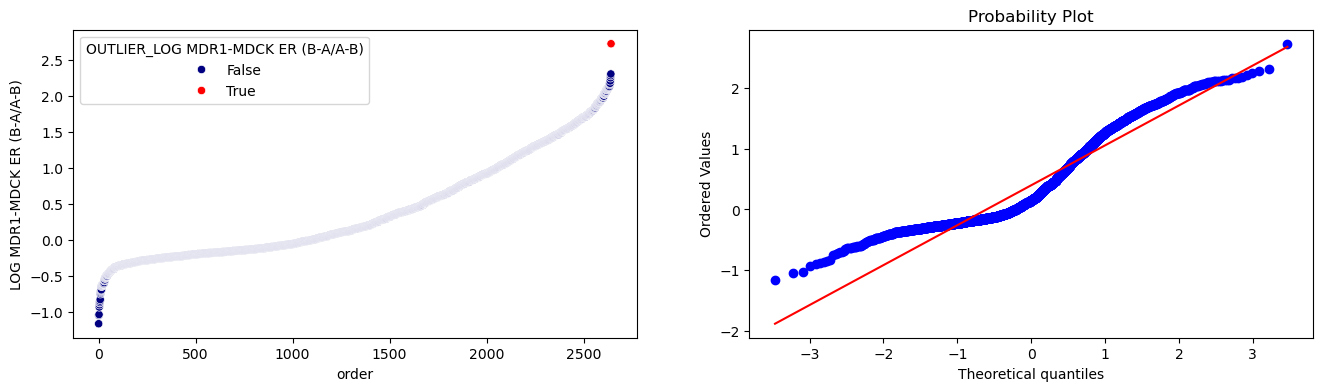

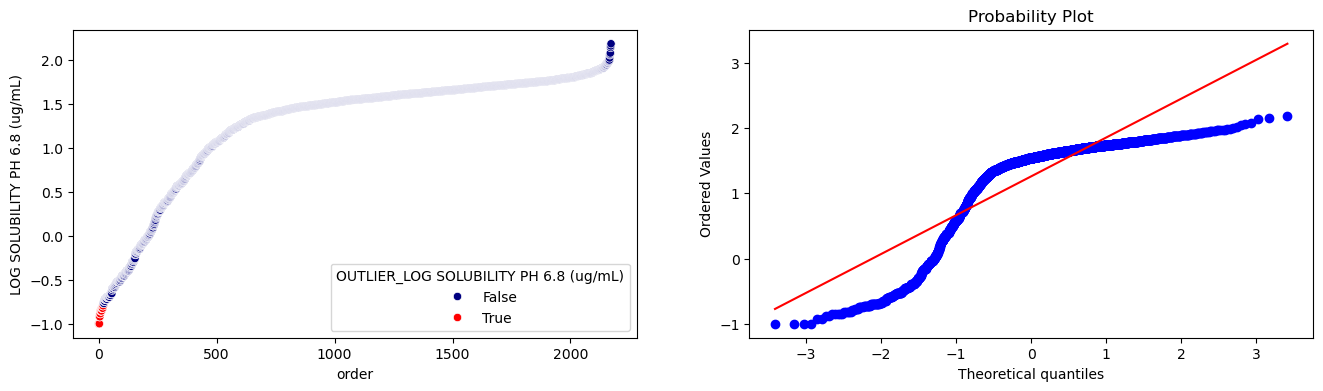

In [8]:
from polaris.curation.viz_utils import visualize_distribution
visualize_distribution(dataset=df_full, data_cols=['LOG HLM_CLint (mL/min/kg)',
                                                 'LOG PLASMA PROTEIN BINDING (RAT) (% unbound)',
                                                 'LOG MDR1-MDCK ER (B-A/A-B)',
                                                 'LOG SOLUBILITY PH 6.8 (ug/mL)'])

On the left side, we have a scatter plot depicting the ordered bioactivity of molecules. This is paired with a probability plot on the right side.

It's worth noting that the flagged outliers, which are located at the extremes of the data distributions, are likely to be false positives. Therefore, they should be examined closely.

### Check the activity shift between the stereo isomers

In [9]:
df_full[[col for col in df_full.columns if "stereo_cliff" in col]].sum()

LOG HLM_CLint (mL/min/kg)_stereo_cliff                         0
LOG RLM_CLint (mL/min/kg)_stereo_cliff                         0
LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)_stereo_cliff    0
LOG PLASMA PROTEIN BINDING (RAT) (% unbound)_stereo_cliff      0
LOG MDR1-MDCK ER (B-A/A-B)_stereo_cliff                        0
LOG SOLUBILITY PH 6.8 (ug/mL)_stereo_cliff                     0
dtype: object

In [10]:
df_full

,Internal ID,Vendor ID,SMILES,CollectionName,LOG HLM_CLint (mL/min/kg),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG RLM_CLint (mL/min/kg),...,LOG RLM_CLint (mL/min/kg)_zscore,LOG RLM_CLint (mL/min/kg)_stereo_cliff,LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)_zscore,LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)_stereo_cliff,LOG PLASMA PROTEIN BINDING (RAT) (% unbound)_zscore,LOG PLASMA PROTEIN BINDING (RAT) (% unbound)_stereo_cliff,LOG MDR1-MDCK ER (B-A/A-B)_zscore,LOG MDR1-MDCK ER (B-A/A-B)_stereo_cliff,LOG SOLUBILITY PH 6.8 (ug/mL)_zscore,LOG SOLUBILITY PH 6.8 (ug/mL)_stereo_cliff
0,Mol2754,49006909,O=C(NCC1(Sc2ccccc2)CC1)c1ccc(=O)[nH]n1,emolecules,0.896416,NaN,NaN,NaN,NaN,2.753398,...,0.520829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mol1188,LN01313047,CC(/C=C/C(=O)NO)=C\[C@@H](C)C(=O)c1ccc(N(C)C)cc1,labnetworkBB,1.366610,0.723417,1.344392,NaN,NaN,2.180917,...,-0.153249,NaN,NaN,NaN,NaN,NaN,0.989082,NaN,-0.732932,NaN
2,Mol1585,32419804,CCNc1ccnc(N(C)Cc2nc3ccccc3n2C)n1,emolecules,1.469100,0.107651,1.567849,NaN,NaN,2.637425,...,0.384274,NaN,NaN,NaN,NaN,NaN,-0.079177,NaN,0.092429,NaN
3,Mol1297,32278068,Clc1ccc(C2(c3ccc(-c4cn[nH]c4)cc3)CCNCC2)cc1,emolecules,0.675687,1.995635,1.267172,NaN,NaN,1.027920,...,-1.510867,NaN,NaN,NaN,NaN,NaN,3.196185,NaN,-1.018154,NaN
4,Mol1364,4752649,c1ccc(-n2ncc3c(-n4ccnc4)ncnc32)cc1,emolecules,1.204093,-0.209238,0.696356,NaN,NaN,2.575138,...,0.310934,NaN,NaN,NaN,NaN,NaN,-0.628933,NaN,-3.126516,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,Mol2093,82736647,CC(=O)c1ccccc1-c1cccc(C(=O)NCCCN2CCCC2)c1,emolecules,0.675687,2.124927,NaN,NaN,NaN,2.870665,...,0.658907,NaN,NaN,NaN,NaN,NaN,3.420487,NaN,NaN,NaN
3517,Mol2519,30194144,COc1ccccc1C(=O)CSc1nncn1C1CC1,emolecules,1.390847,0.113544,NaN,NaN,NaN,2.665128,...,0.416894,NaN,NaN,NaN,NaN,NaN,-0.068955,NaN,NaN,NaN
3518,Mol3304,11847209,CCOC(=O)N1CCC(C(=O)Nc2cccc(C)c2)CC1,emolecules,NaN,NaN,1.750354,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.766527,NaN
3519,Mol2518,30663852,O=C(CSc1ccccn1)N1CCSc2ccccc21,emolecules,2.629072,-0.232005,NaN,NaN,NaN,3.805995,...,1.760229,NaN,NaN,NaN,NaN,NaN,-0.668430,NaN,NaN,NaN


### Check the molecules with undefined stereocenters

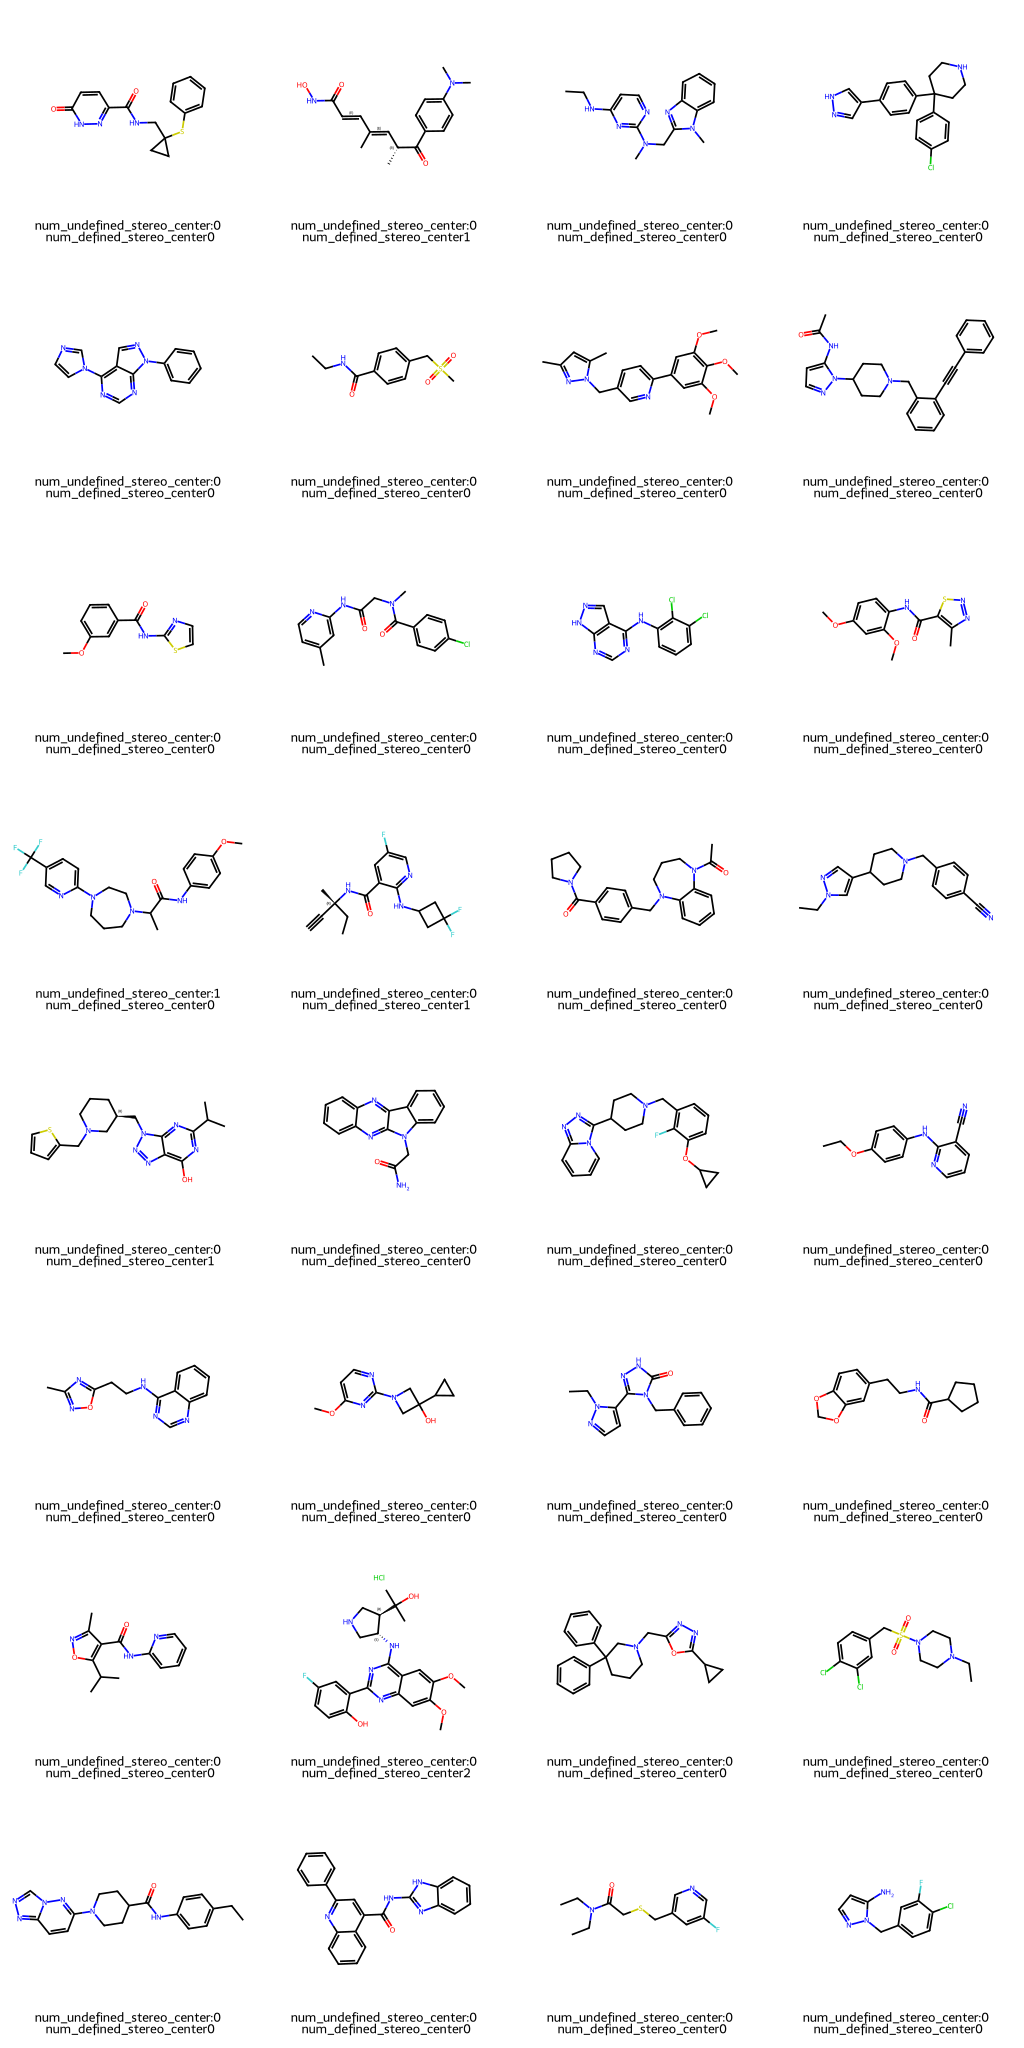

In [11]:
df_full["mol"] = df_full[mol_col].apply(dm.to_mol)
fig = check_undefined_stereocenters(dataset=df_full)
fig

The stereo center of the above molecules are unspecified. However, there are no activity shifts have been detected between their stereo isomers within this dataset. As a result, we will continue to include these molecules in the dataset for now.

## Chemical space

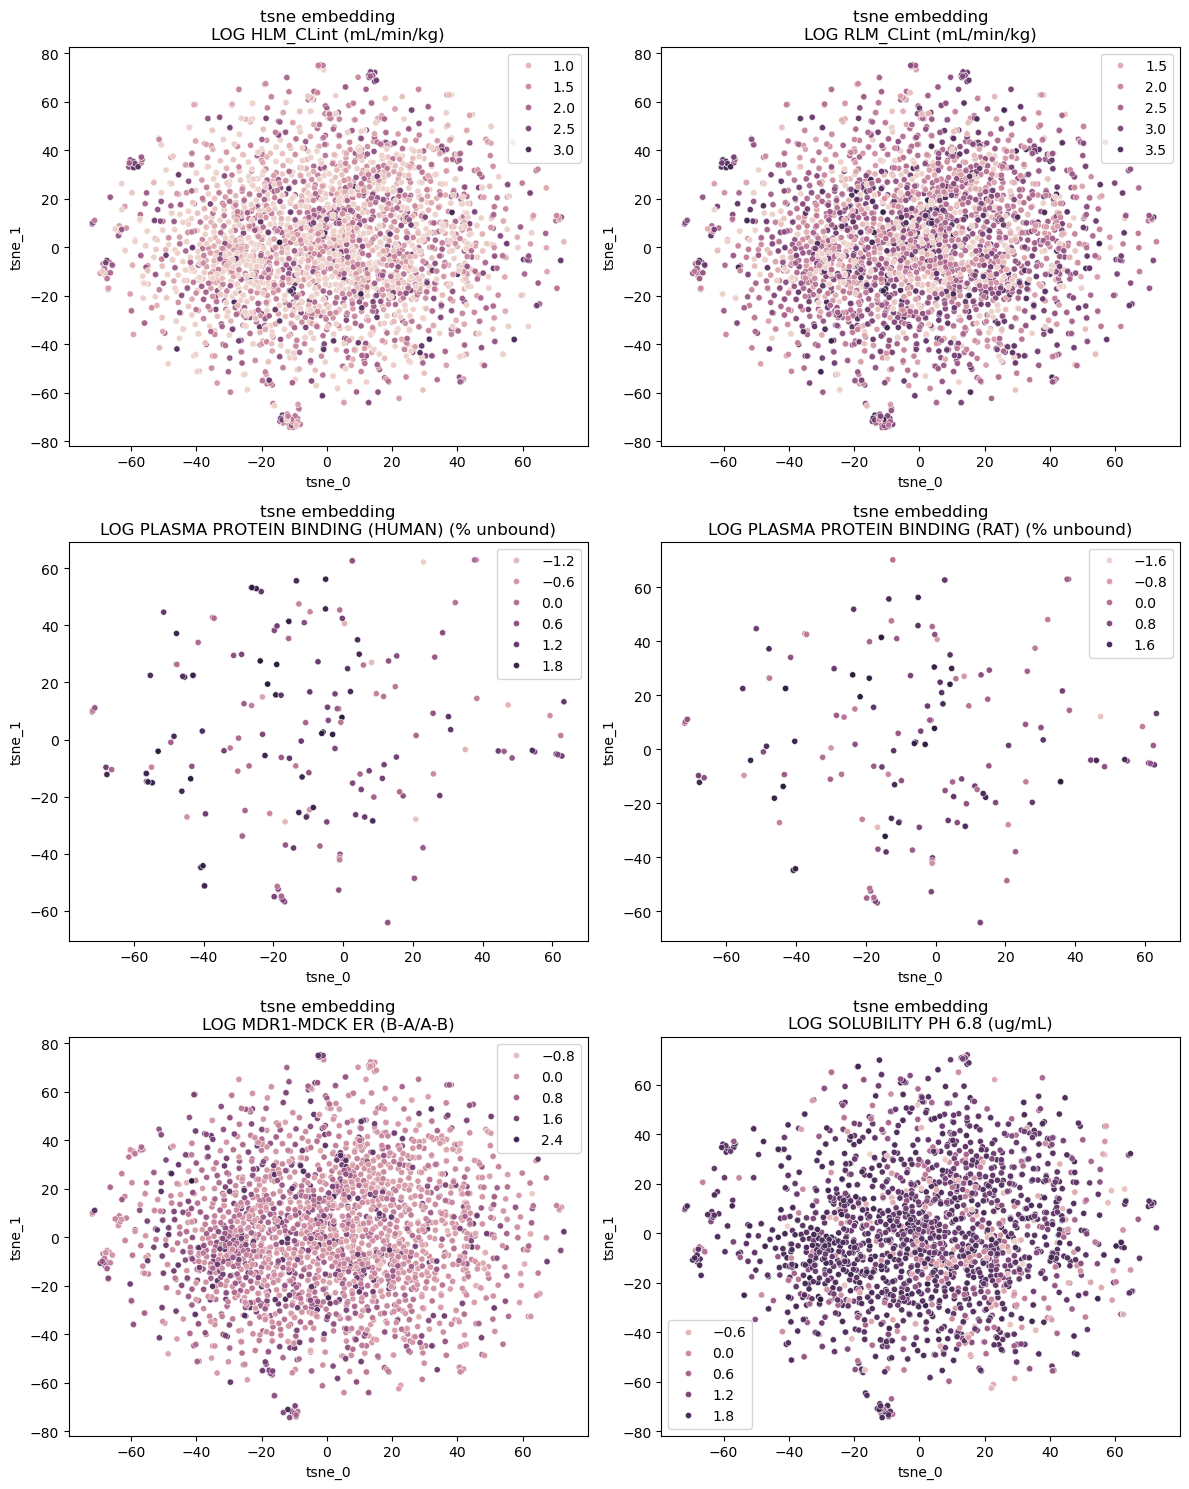

In [16]:
from utils import display_chemspace

fig = display_chemspace(df_full.copy(), mol_col="smiles", data_cols=data_cols, nrows=3)

## Perform data curation and export curated data
After the above data auditing result, we can conculde that 
there is no activity shifts among the sterero isomers. Therefore, it's not necessary to remove the molecules with undefined stereo centers from the dataset. 


In [13]:
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,  
    keep_all_rows = False # merge the bioactivities of replicated molecules.
)
df_curated = curator()

2024-03-25 16:23:10.572 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOG HLM_CLint (mL/min/kg) using zscore. Please revise the data and consider remove the outliers. 
2024-03-25 16:23:10.575 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG PLASMA PROTEIN BINDING (RAT) (% unbound) using zscore. Please revise the data and consider remove the outliers. 
2024-03-25 16:23:10.576 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG MDR1-MDCK ER (B-A/A-B) using zscore. Please revise the data and consider remove the outliers. 
2024-03-25 16:23:10.577 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 20 outliers for data column LOG SOLUBILITY PH 6.8 (ug/mL) using zscore. Please revise the data and consider remove the outliers. 


**Export curated data**

In [14]:
fout = "gs://polaris-public/data/ADME/fang2023_public_set_3521_curated.csv"
df_curated.reset_index(drop=True).to_csv(fout, index=False)